In [46]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy
from pySOT.optimization_problems import Rosenbrock
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [47]:
class DixonPrice(Rosenbrock):
    """Three-hump camel function

    Details: https://www.sfu.ca/~ssurjano/camel6.html


    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """
    
    def __init__(self, dim=10,ep = 1):
        self.min = 0
        self.dim = dim
        self.minimum = np.array([2**(-((2)**(i) - 2)/2**i) for i in range(1,dim+1)])
        self.lb = -10.0 * np.ones(dim)
        self.ub = 10.0 * np.ones(dim)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, dim)
        self.info = "d-dimensional Dixon-Price function "

    def eval(self, x):
        """Evaluate the Three Hump Camel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        return (x[0] - 1)**2 + np.sum(np.array([i*(2*x[i]**2 - x[i - 1])**2 for i in range(1,self.dim)]))

In [48]:
class Lm_DixonPrice(DixonPrice):

    
    def __init__(self,ep = 1,dim = 10):
        self.ep = ep
        DixonPrice.__init__(self,dim)
        #self.c = self.eval(np.random.random(size = self.dim))
        self.c = 0
        self.H_ys = []
        self.beta = 1/ep
        

            # linear f
    def eval1(self, x):
        """Evaluate the modified ThreeHumpCamel function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified ThreeHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified ThreeHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
           # self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )

In [49]:
def ex_helper(times):
    max_evals = 300
    l2 = np.zeros((max_evals,times))
    for i in range(times):
        np.random.seed(i)
        random.seed(i)
        lm_dixonPrice = Lm_DixonPrice()
        rbf = RBFInterpolant(dim=lm_dixonPrice.dim, lb=lm_dixonPrice.lb, ub=lm_dixonPrice.ub, kernel=CubicKernel(), tail=LinearTail(lm_dixonPrice.dim))
        slhd = SymmetricLatinHypercube(dim=lm_dixonPrice.dim, num_pts=2 * (lm_dixonPrice.dim + 1))
        controller1 = SerialController(objective=lm_dixonPrice.eval)
        controller1.strategy = SRBFStrategy(
            max_evals=max_evals, opt_prob=lm_dixonPrice, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
            )

        # Run the optimization strategy
        result1 = controller1.run()
        l2[:,i] = np.array(
                [o.value for o in controller1.fevals if o.value is not None])
    return l2

In [50]:
l2 = ex_helper(30)

KeyboardInterrupt: 

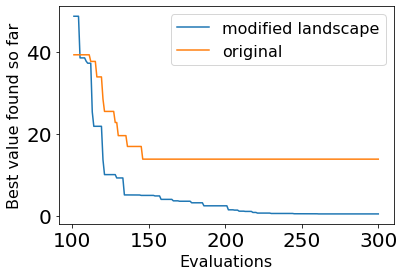

0.5393444380312539 13.86543486622311


(0.5393444380312539, 13.86543486622311)

In [61]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/plots'


    
def example_simple(state,path,i,l2):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 300
    
    lm_DixonPrice = Lm_DixonPrice()
    rbf = RBFInterpolant(dim=lm_DixonPrice.dim, lb=lm_DixonPrice.lb, ub=lm_DixonPrice.ub, kernel=CubicKernel(), tail=LinearTail(lm_DixonPrice.dim))
    slhd = SymmetricLatinHypercube(dim=lm_DixonPrice.dim, num_pts=2 * (lm_DixonPrice.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_DixonPrice.eval1)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_DixonPrice, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

    # Run the optimization strategy
    result = controller.run()
    l1 = lm_DixonPrice.H_ys

    fvals1 = np.minimum.accumulate(l1)
    fvals2 = np.minimum.accumulate(l2[:,i])
    for results in [fvals1[100:300],fvals2[100:300]]:
        plt.errorbar(np.arange(start = 100, stop = 300)+1, y=results)
    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    #plt.title('using linear f, best value using landscape modification is {0} and other is {1}'.
     #         format(lm_DixonPrice.eval(result.params[0]),min(l2[:,i])),
      #        fontsize = 18)
    #plt.figure(facecolor=(1, 1, 1))
    plt.savefig(path + '/graph_iter_{0}.png'.format(i), dpi = 100)
    plt.show()

    print(lm_DixonPrice.eval(result.params[0]),min(l2[:,i]))
    return lm_DixonPrice.eval(result.params[0]),min(l2[:,i])

example_simple(24,path,24,l2)

In [57]:
def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path,l2):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    for i in range(times):
        res = example_simple(i,path,i,l2)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('dixon price, quadratic landscape modification, adaptive c')
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('standard_deviation of landscape modified is {}'.format(np.std(lm_list)))
    print('standard_deviation of non landscape modified is {}'.format(np.std(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list
    

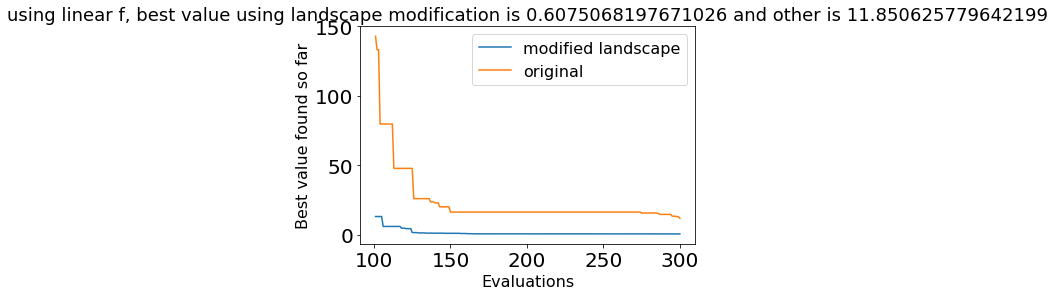

0.6075068197671026 11.850625779642199


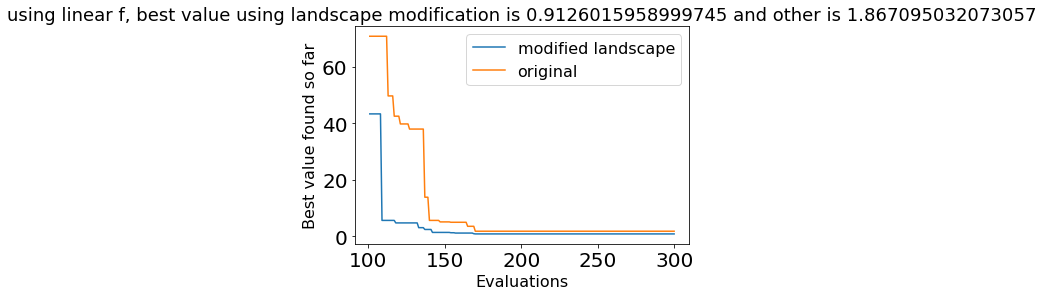

0.9126015958999745 1.867095032073057


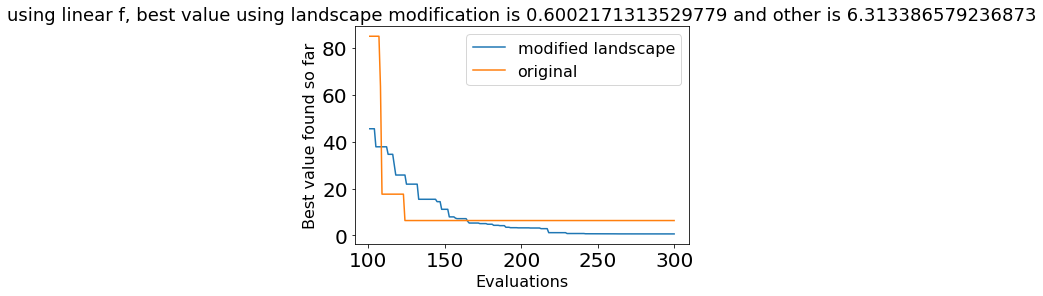

0.6002171313529779 6.313386579236873


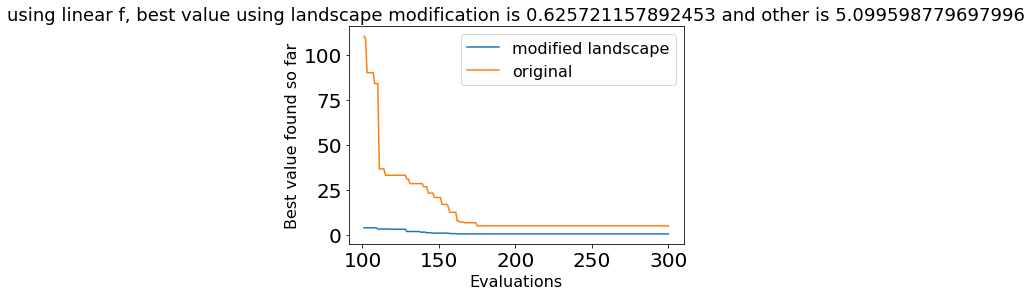

0.625721157892453 5.099598779697996


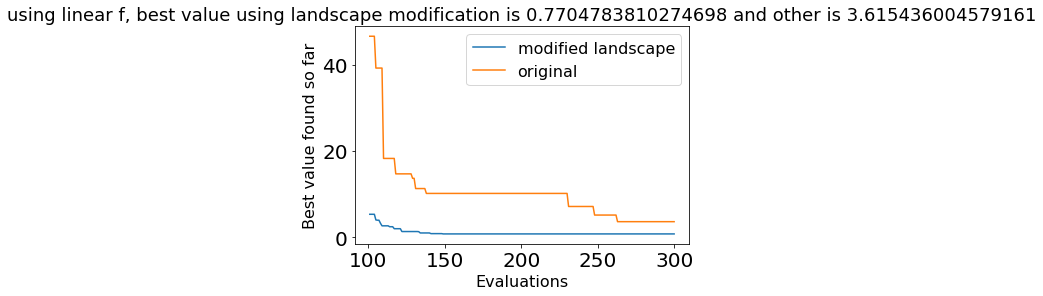

0.7704783810274698 3.615436004579161


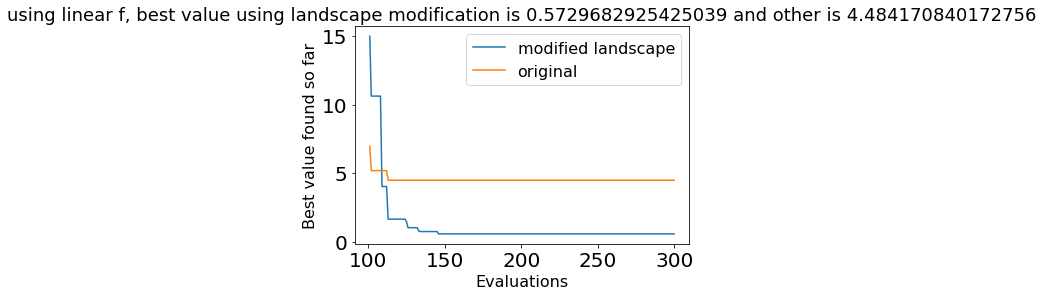

0.5729682925425039 4.484170840172756


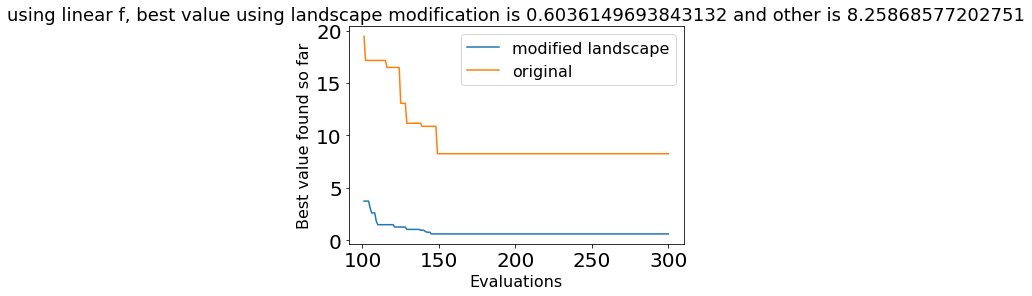

0.6036149693843132 8.25868577202751


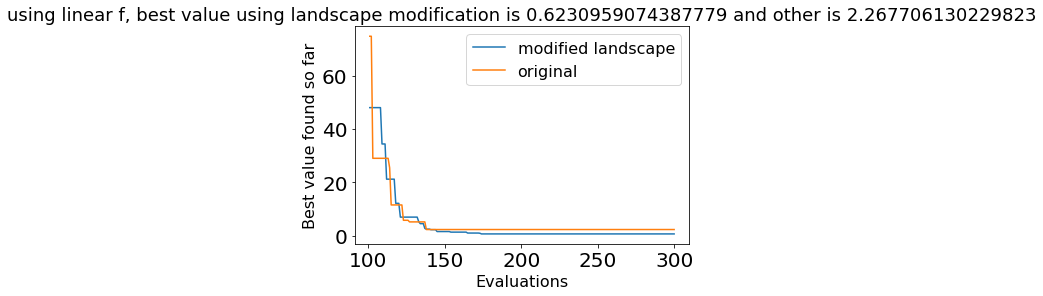

0.6230959074387779 2.267706130229823


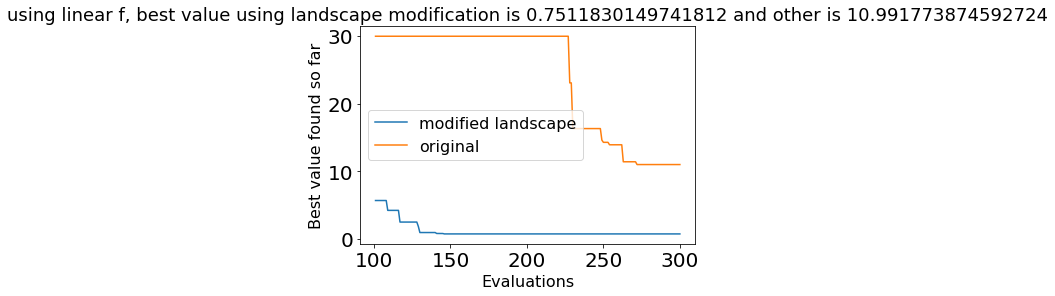

0.7511830149741812 10.991773874592724


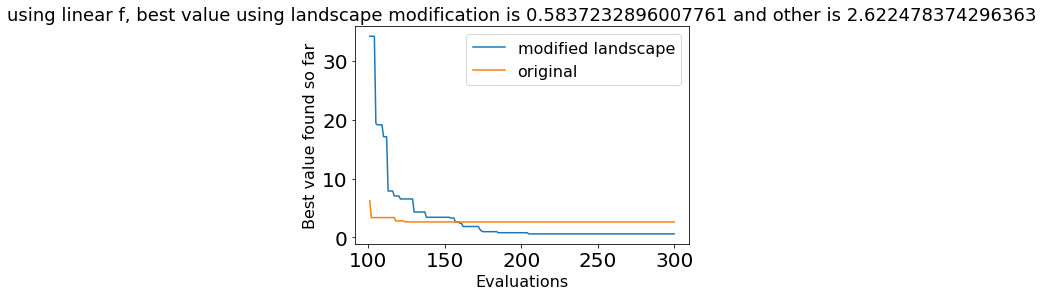

0.5837232896007761 2.622478374296363


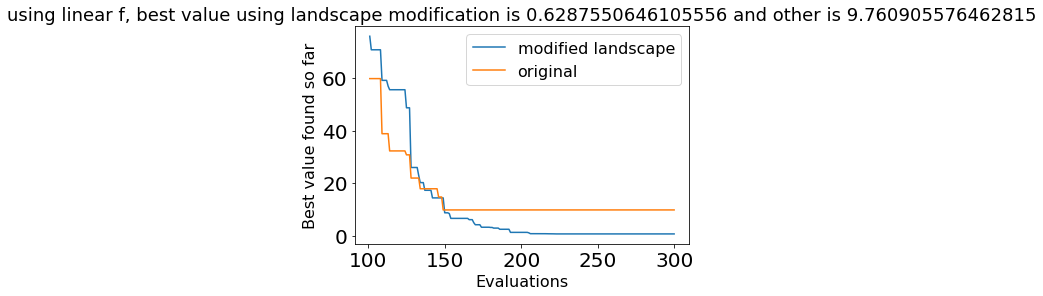

0.6287550646105556 9.760905576462815


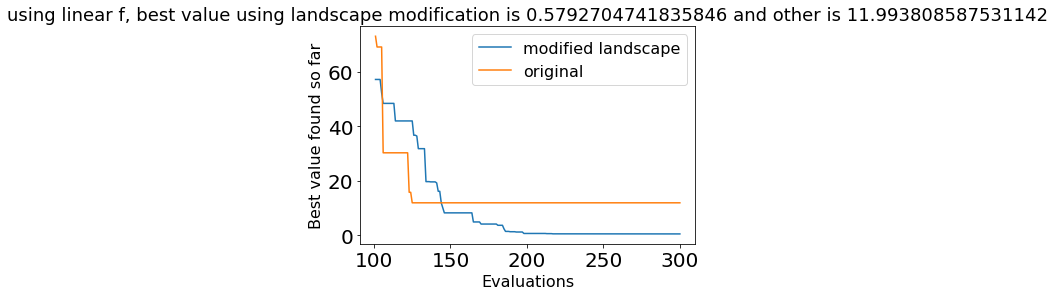

0.5792704741835846 11.993808587531142


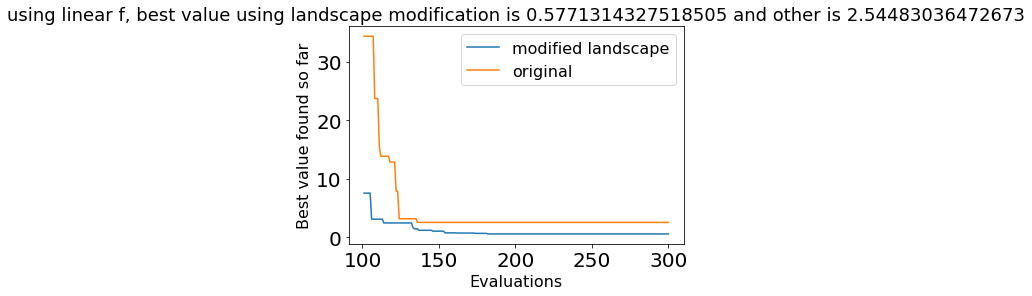

0.5771314327518505 2.54483036472673


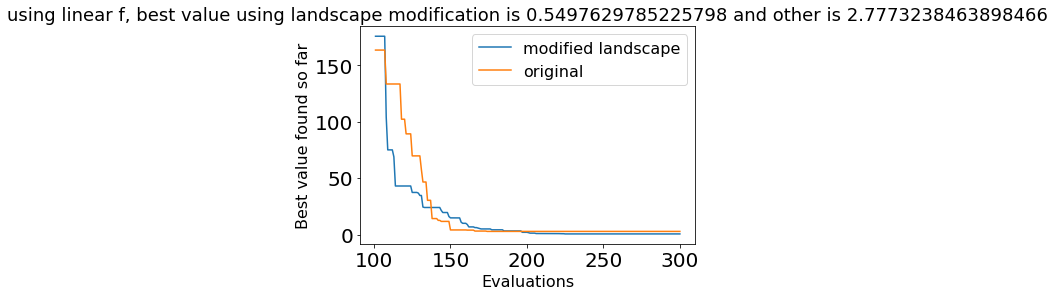

0.5497629785225798 2.7773238463898466


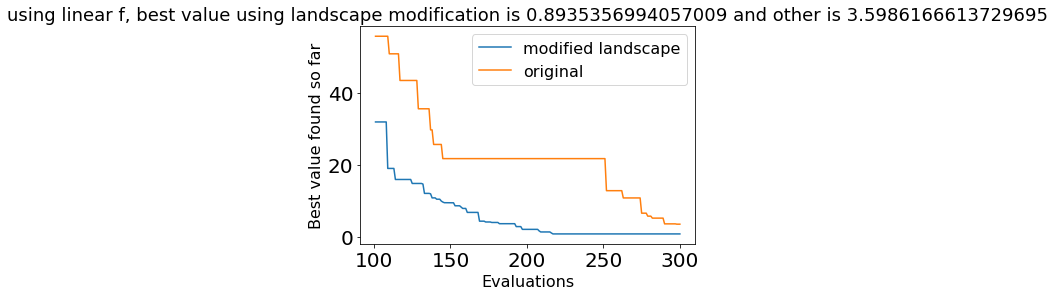

0.8935356994057009 3.5986166613729695


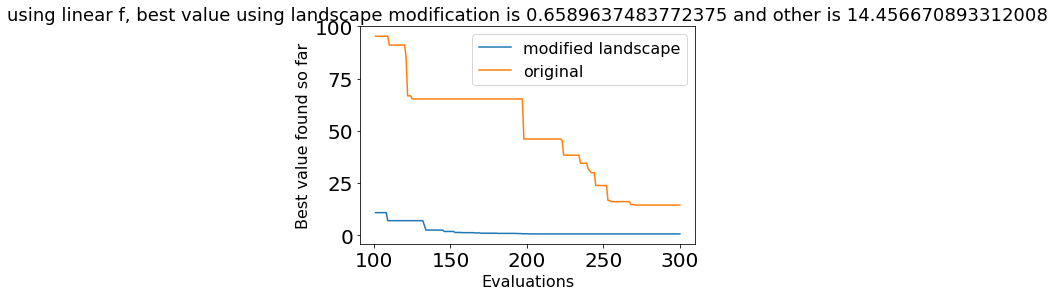

0.6589637483772375 14.456670893312008


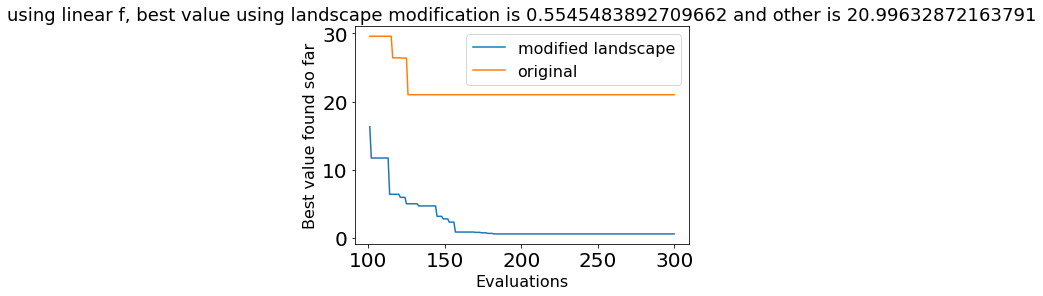

0.5545483892709662 20.99632872163791


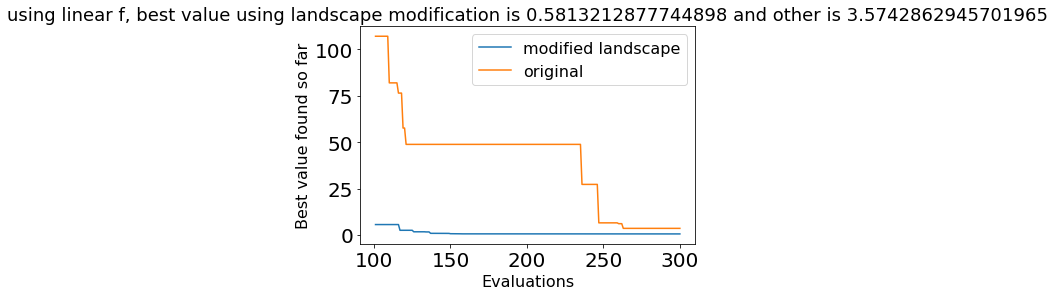

0.5813212877744898 3.5742862945701965


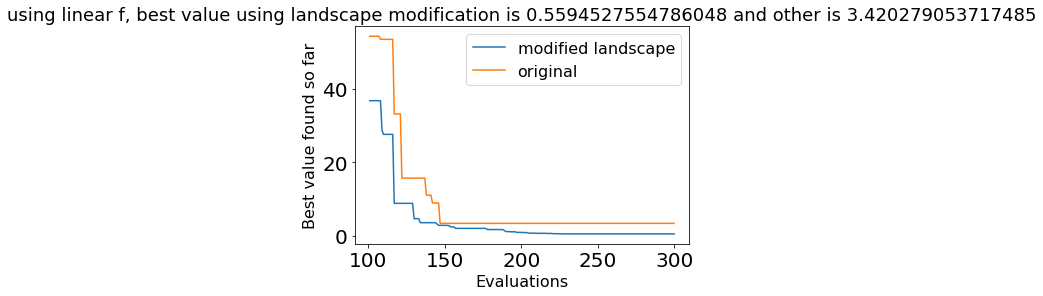

0.5594527554786048 3.420279053717485


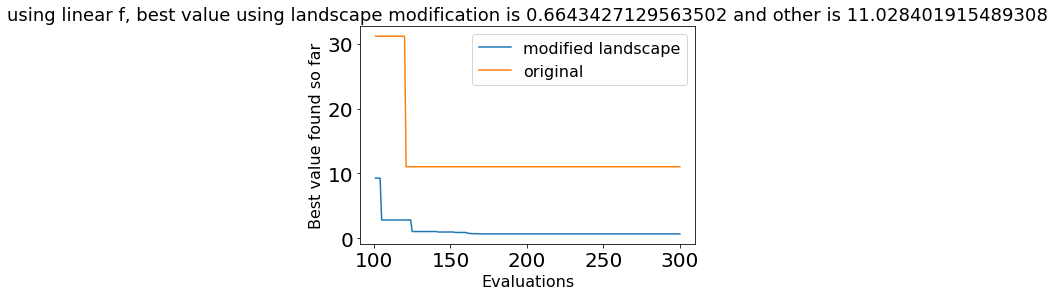

0.6643427129563502 11.028401915489308


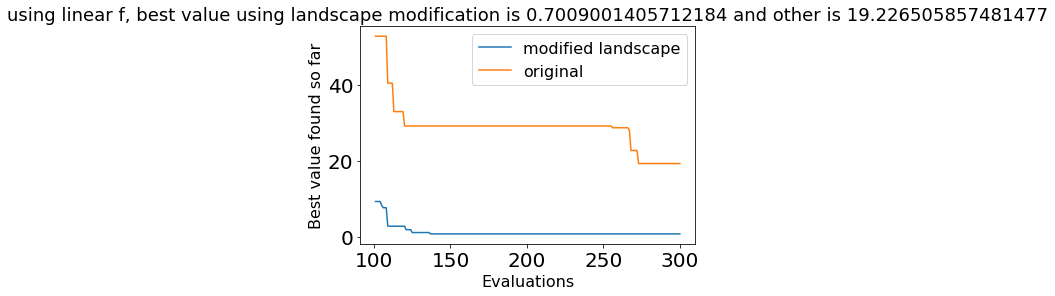

0.7009001405712184 19.226505857481477


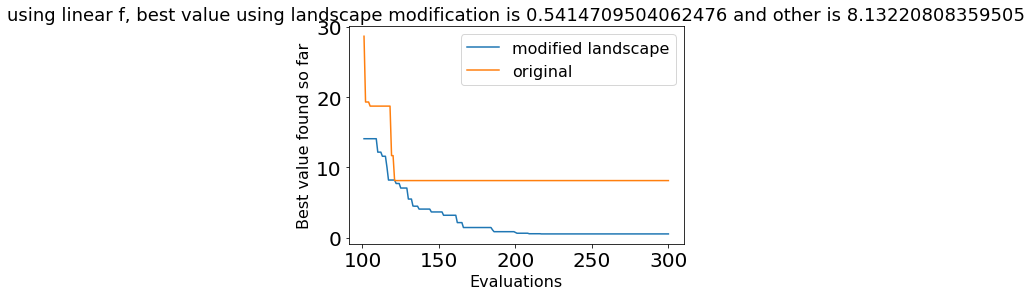

0.5414709504062476 8.13220808359505


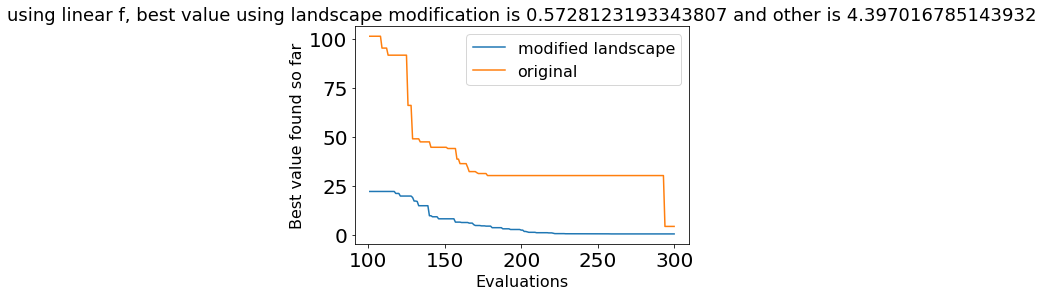

0.5728123193343807 4.397016785143932


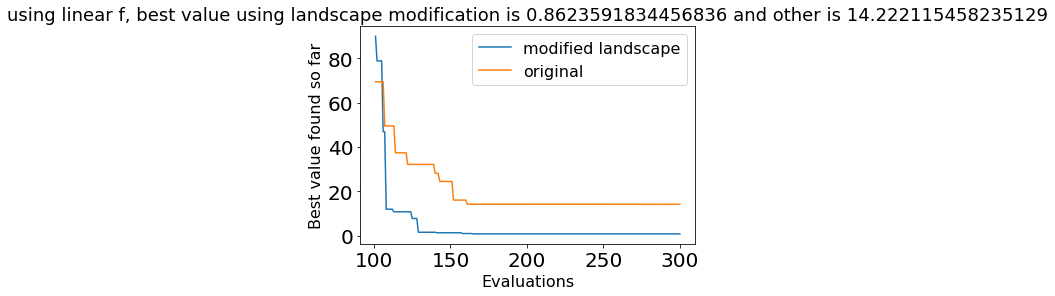

0.8623591834456836 14.222115458235129


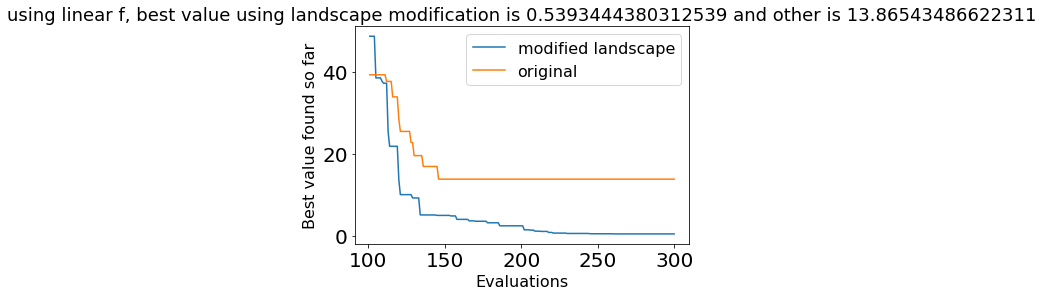

0.5393444380312539 13.86543486622311


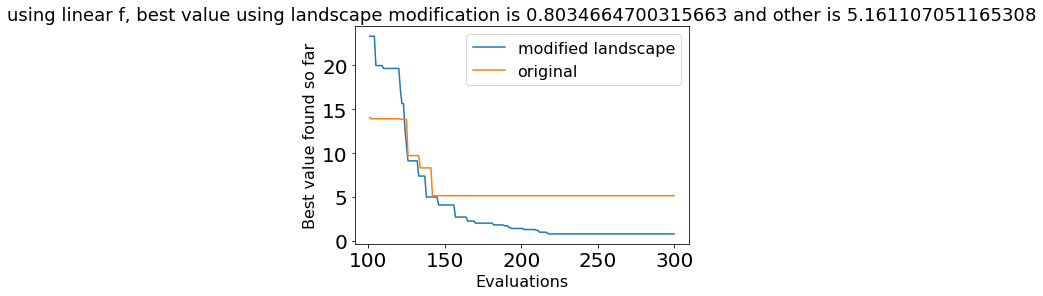

0.8034664700315663 5.161107051165308


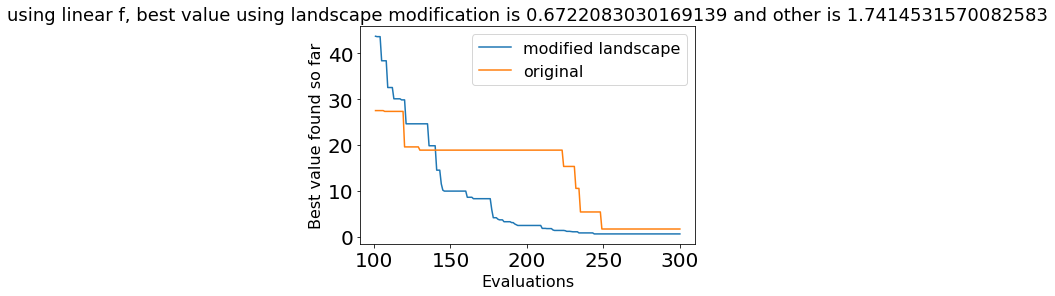

0.6722083030169139 1.7414531570082583


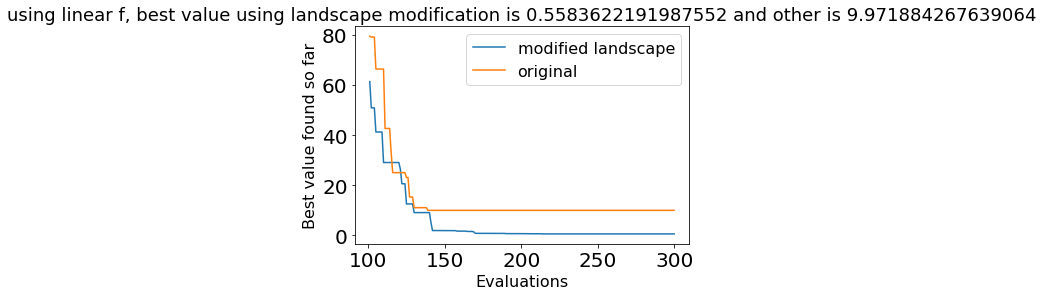

0.5583622191987552 9.971884267639064


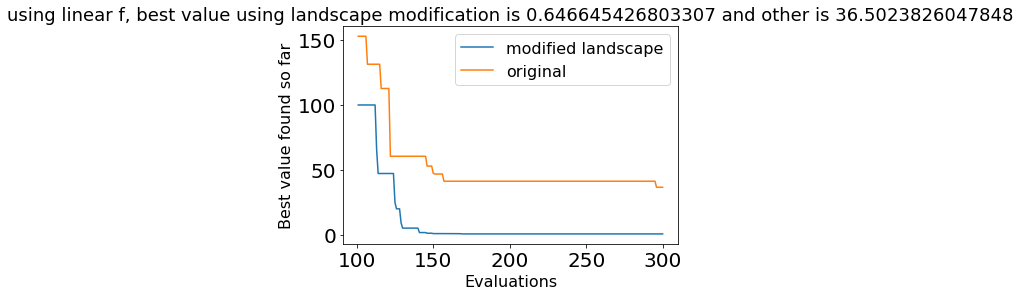

0.646645426803307 36.5023826047848


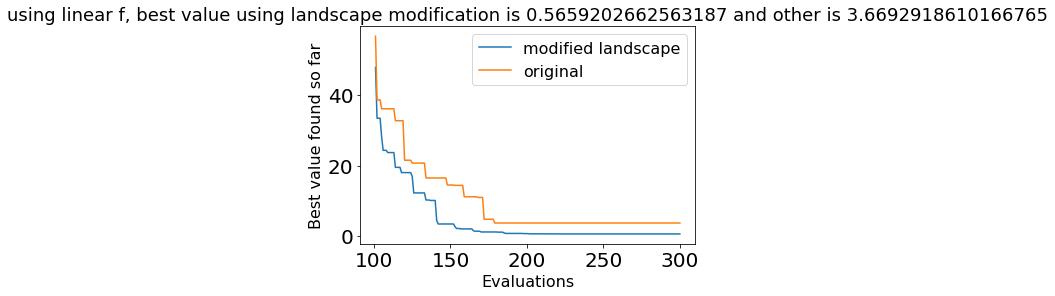

0.5659202662563187 3.6692918610166765
dixon price, quadratic landscape modification, adaptive c
landscape modified was better 30 times and was worse 0 times
mean of landscape modified is 0.6453894940102699
mean of non landscape modified is 8.613726969135056
median of landscape modified is 0.6055608945757079
median of non landscape modified is 5.7372468152010905
standard_deviation of landscape modified is 0.10500405846617884
standard_deviation of non landscape modified is 7.314301579409747
best result of landscape modified is 0.5393444380312539
best of non landscape modified is 1.7414531570082583
worst result of landscape modified is 0.9126015958999745
worst of non landscape modified is 36.5023826047848


([0.6075068197671026,
  0.9126015958999745,
  0.6002171313529779,
  0.625721157892453,
  0.7704783810274698,
  0.5729682925425039,
  0.6036149693843132,
  0.6230959074387779,
  0.7511830149741812,
  0.5837232896007761,
  0.6287550646105556,
  0.5792704741835846,
  0.5771314327518505,
  0.5497629785225798,
  0.8935356994057009,
  0.6589637483772375,
  0.5545483892709662,
  0.5813212877744898,
  0.5594527554786048,
  0.6643427129563502,
  0.7009001405712184,
  0.5414709504062476,
  0.5728123193343807,
  0.8623591834456836,
  0.5393444380312539,
  0.8034664700315663,
  0.6722083030169139,
  0.5583622191987552,
  0.646645426803307,
  0.5659202662563187],
 [11.850625779642199,
  1.867095032073057,
  6.313386579236873,
  5.099598779697996,
  3.615436004579161,
  4.484170840172756,
  8.25868577202751,
  2.267706130229823,
  10.991773874592724,
  2.622478374296363,
  9.760905576462815,
  11.993808587531142,
  2.54483036472673,
  2.7773238463898466,
  3.5986166613729695,
  14.456670893312008,
 

In [45]:
checker(30,path,l2)